# Eliminación de anomalías de una imagen

## Introducción

## Librerías a utilizar
En la presente trabajo se usarán las librerías OpenCV para el procesamiento de imágenes y Numpy para manejar las imágenes como si fueran arreglos bidimensionales.

In [1]:
import cv2 as cv
import numpy as np

La librería matplotlib será usada para presentar las imágenes dentro del notebook de python. Esta librería espera imágenes RGB de otra manera los tonos y colores serán distintos. Para ver las imágenes de salida con detalle es necesario ir a la carpeta `out`. Las imágenes de entrada se encuentran en la carpeta `im`.

In [2]:
from matplotlib import pyplot as plt

## Carga de imágenes

En este trabajo usaremos tres imágenes base:
    
1. `unir-1.jpg`: Es la imagen que servirá como control. No tiene anomalías aparentes.
2. `salt-pepper.png`: Esta imagen es obtenida de internet, tiene ruido conocido como _sal y pimienta_.
3. `noisy.jpg`: Esta es una imagen antigua tomada en 2008 con una cámara Nikon, el ruido que presenta lo supondremos como _gausiano_.

In [3]:
image_unir = cv.imread('im/unir-1.jpg')
image_snp = cv.imread('im/salt-pepper.png')
image_noisy = cv.imread('im/noisy.jpg')

## Filtro de convolución por promedio

En un filtro de convolución por promedio, el sistema pasa fácilmente los componentes de baja frecuencia de la señal y suprime los componentes de alta frecuencia. Cuando se aplica a una imagen, reemplaza cada píxel en la entrada por el promedio de los valores de un conjunto de sus píxeles vecinos [...] Las anomalías se suavizan debido al promedio. La borrosidad aumentará proporcionalmente con filtros más grandes. Este filtro es separable. Multiplicando el filtro de columna con el filtro de fila, que es la transposición del filtro de columna, obtenemos el filtro promedio.(cite https://doi.org/10.1007/978-981-10-6113-4 cap. 2.4.2)

Para usar este filtro primero es necesario crear una función que genere rápidamente una máscara de tamaño nxn. Está máscara es un arreglo con valores 1 y será multiplicado por un escalar que permita obtener el promedio.

In [4]:
def mask(n):
    '''Define a nxn mask.
    Useful for a quick filter
    '''
    mask = np.ones((n,n), np.float32)*(1/(n**2))
    return mask
# Obtener una máscara particular de tamaño 5x5
kernel = mask(5)
print(kernel)

[[0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]
 [0.04 0.04 0.04 0.04 0.04]]


Ahora se debe probar con la función `cv.filter2D()`. No es necesario hacer nuevas funciones. Usaremos la imagen de control para observar el efecto del filtro.

In [5]:
im = image_unir
# El filtro recibe como parámetros: 1. la imagen, 2. la profundidad, -1 conserva el valor original, 3. el kernel a aplicar.
out_5 = cv.filter2D(im,-1,kernel)
cv.imwrite('out/filter2D.jpg', out_5)
kernel = mask(50)
out_50 = cv.filter2D(im,-1,kernel)
cv.imwrite('out/filter2D-bigKernel.jpg', out_50)

True

Puede observarse como resultado del filtro que la imagen se difumina ligeramente, sobre todo en el texto. Ahora si el valor de la máscara es muy alto, por ejemplo 50, se notará un fuerte efecto de difuminado en la imagen.

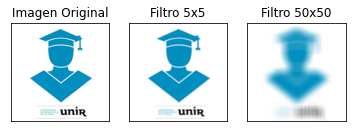

In [6]:
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
out_5 = cv.cvtColor(out_5, cv.COLOR_BGR2RGB)
out_50 = cv.cvtColor(out_50, cv.COLOR_BGR2RGB)
plt.subplot(131)
plt.imshow(im)
plt.title('Imagen Original'), plt.xticks([]), plt.yticks([])
plt.subplot(132)
plt.imshow(out_5)
plt.title('Filtro 5x5'), plt.xticks([]), plt.yticks([])
plt.subplot(133)
plt.imshow(out_50)
plt.title('Filtro 50x50'), plt.xticks([]), plt.yticks([])
plt.show()

El efecto de limpieza de ruido con este filtro pasa baja (LPF) puede observarse al usarlo con las imágenes guardadas un las variables `image_noisy` e `image_snp`.

In [7]:
# Mantener comentada una de las próximas dos líneas para observar el resultado del filtro
im = image_noisy
#im = image_snp
# Cambie el tamaño de la máscara si así lo desea
kernel = mask(10)
out = cv.filter2D(im,-1,kernel)
cv.imwrite('out/filter2D-cleaning.jpg', out)

True

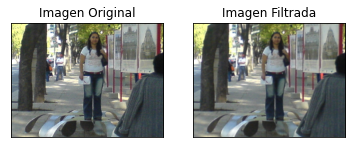

In [8]:
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
out = cv.cvtColor(out, cv.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.imshow(im)
plt.title('Imagen Original')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2) 
plt.imshow(out)
plt.title('Imagen Filtrada')
plt.xticks([])
plt.yticks([])
plt.show()

Es notorio que este filtro tiene un efecto relativo sobre el ruido: en el caso _sal y pimienta_ limpia muy poco la imagen debido a que se encarga de las anomalías de alta frecuencia (la sal) pero no soluciona las anomalías de baja frecuencia, mientras tanto, en sobre el ruido gausiano la mejora es más notoria. Ahora se procederá a comparar este filtro con otros más y comparar los resultados.

## Filtro gausiano

Los LPF gaussianos se basan en la función de distribución de probabilidad gaussiana. El filtro gaussiano es ampliamente utilizado. Las características de este filtro incluyen:

1. Simetría.
2. Al variar el valor de la desviación estándar, se controla el requisito conflictivo de menos borrosidad y más eliminación de ruido.
3. Los coeficientes caen a niveles insignificantes en los bordes.
4. La transformada de Fourier de una función gaussiana es otra función gaussiana.
5. La convolución de dos funciones gaussianas es otra función gaussiana.

Probarémos este filtro con la imagen almacenada en `image_noisy`, debido a la naturaleza de dicho ruido.

In [28]:
im = image_noisy
# Los parámetros principales son: 1. imagen, 2. Kernel gaussiano (puede ser solo las dimensiones) 3. Desviación estándar.
out = cv.GaussianBlur(im,(9,9),100)
cv.imwrite('out/gaussian.jpg', out)

True

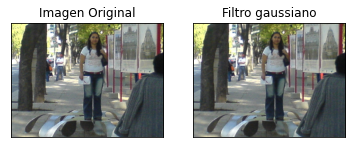

In [10]:
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
out = cv.cvtColor(out, cv.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.imshow(im)
plt.title('Imagen Original')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2) 
plt.imshow(out)
plt.title('Filtro gaussiano')
plt.xticks([])
plt.yticks([])
plt.show()

In [11]:
## Filtro de mediana

In [12]:
im = image_snp
out = cv.medianBlur(im,5)
cv.imwrite('out/median-cv.jpg', out)

True

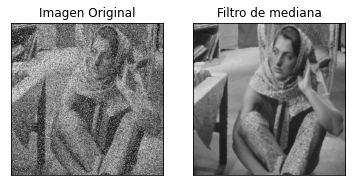

In [13]:
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
out = cv.cvtColor(out, cv.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.imshow(im)
plt.title('Imagen Original')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2) 
plt.imshow(out)
plt.title('Filtro de mediana')
plt.xticks([])
plt.yticks([])
plt.show()

### Otra implementación

El filtro de mediana se usa para eliminar el ruido _sal y pimienta_. Esta primera implementación es tomada de un [código de Github](https://github.com/MeteHanC/Python-Median-Filter/blob/master/MedianFilter.py).

In [14]:
def median_filter(data, filter_size):
    """Apply the median filter.
    
    Arguments:
    data -- An array that represents an image.
    filter_size -- An impair integer that represents mask/window size.
    
    Return a filtered array that represents an image.
    """
    if (filter_size % 2) == 0:
        raise TypeError("filter_size must be an impair integer")
    if not isinstance(data, np.ndarray):
        raise TypeError("data must be an array")
    indexer = filter_size // 2
    mask = [ # Crea un arreglo del tamaño adecuado
        (i, j)
        for i in range(-indexer, filter_size-indexer)
        for j in range(-indexer, filter_size-indexer)
    ]
    index = len(mask) // 2
    # Recorre data
    for i in range(len(data)):
        for j in range(len(data[0])):
            # Ordena data
            data[i][j] = sorted(
                # Será 0 si es un límite de la imagen
                0 if (
                    min(i+a, j+b) < 0
                    or len(data) <= i+a
                    or len(data[0]) <= j+b
                ) else data[i+a][j+b] # De otro modo será el valor de en la imagen
                # Eso lo recorre en cada punto de la máscara
                for a, b in mask
            )[index] # Toma el valor de la mediana una vez ordanada data
    return data

In [15]:
from PIL import Image

im = Image.open('im/salt-pepper.png')
input = np.asarray(im)
out = median_filter(input, 3)
Image.fromarray(out).save("out/median-alg.jpg")

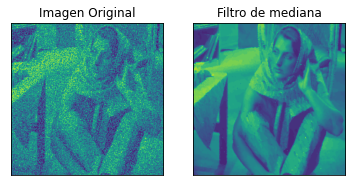

<Figure size 432x288 with 0 Axes>

In [16]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(im)
plt.title('Imagen Original')
plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2) 
plt.imshow(out)
plt.title('Filtro de mediana')
plt.xticks([])
plt.yticks([])
plt.show()
plt.savefig('out/testing.png')

#EOF